In [2]:
import importlib
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib

import MSM_methods

import utility_v1
import propagators_v2
import energy_landscapes_v1

import parallel_simulations_v2
import weighted_ensemble_v2
import metadynamics_v1
import multiple_walker_metadynamics_v2
import we_mtd_v1

import visualization_v1

#methods for fast print debugging #<---- these probably belong in utility_v1.py
def p(x):
    print(x)
def pl(x):
    print(len(x))
def ps(x):
    print(x.shape)

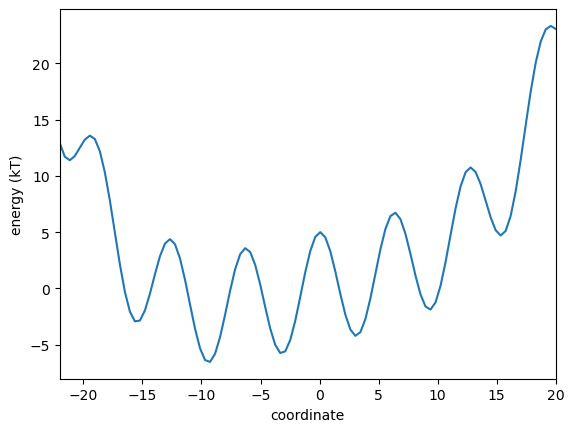

In [3]:
# kT = 1
# dt = 0.01

# importlib.reload(energy_landscapes_v1)

system1 = energy_landscapes_v1.deep_sine_well()
system1.plot_quantity(system1.potential)
plt.xlabel("coordinate")
plt.ylabel("energy (kT)")
plt.xlim(-22, 20)
plt.savefig("figures/deep_sine_well.png", dpi=600)
# system1.plot_quantity(system1.F)
# plt.show()

bootstrap round 1



---------------------MULTIPLE WALKER METADYNAMICS---------------------
running 256 parallel multiple walker metadynamics simulations
molecular time: 100000 steps;  aggregate time: 25600000 steps
data points saved: 256000 at 100-step intervals
gaussians of height 0.000390625 are added every 100 steps


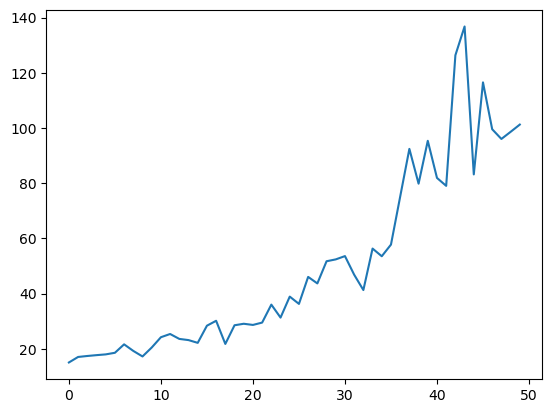

error: no eigenvalue is 1 to within 12 significant figures
using eigenvalue (1.0018043015616456+0j)
error: eigenvector failed to converge after 99 rounds; maximum fractional error of any component = nan


/home/jonathan/Documents/grabelab/sampling-scheme-development/sampling-methods-v3/MSM_methods.py:182: RuntimeWarning: invalid value encountered in divide
  fractional_errors = (eig0c-eig0c_buffer)/eig0c


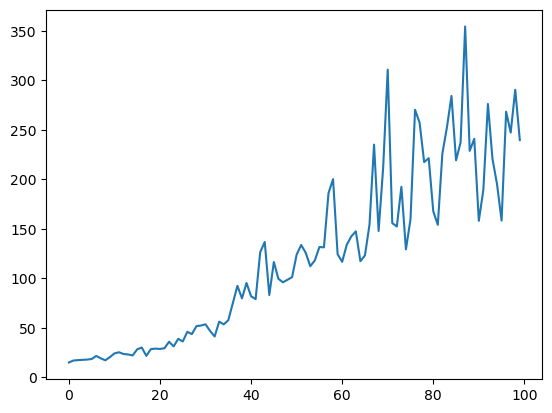

In [ ]:
importlib.reload(utility_v1)
importlib.reload(propagators_v2)
importlib.reload(energy_landscapes_v1)
importlib.reload(MSM_methods)

importlib.reload(parallel_simulations_v2)
importlib.reload(weighted_ensemble_v2)
importlib.reload(metadynamics_v1)
importlib.reload(multiple_walker_metadynamics_v2)
importlib.reload(we_mtd_v1)

importlib.reload(visualization_v1)

#------------------------------system----------------------------------
system1 = energy_landscapes_v1.deep_sine_well()
# system1.plot_quantity(system1.potential)
# system1.plot_quantity(system1.F)
# plt.show()

kT = 1     #Boltzmann factor
dt = 0.01  #integration timestep

#TODO make the parameters below and system (and method hyperparams) into a TEST_SETUP object so we can reproduce ones that worked well
#hyperparameters for estimating convergence
n_timepoints = 20
n_bootstrap = 5

#binning parameters
n_analysis_bins = 200
#save frequency

#simulation time limits (integration steps)
#aggregate_simulation_limit = 2420000 #150000000

#number of parallel simulations that are run at a time.
#this is the maximum number in the case of WE simulations.
# If a WE run requires more than this number of this walkers per WE round, 
# they would have to be run serially and the WE round would 
# consume multiple WE round lengths worth of molecular time.
# the WE implementation in this sofware package does not actually do this under the hood, 
# but calculates how much molecular time would have been consumed if the WE run had been executed on n_parallel GPUs
n_parallel = 256

#note: system can diffuse to uniformly fill hexic well in 50k steps
#so sampling in simulations of at least that timescale is definitely limited by energy barriers rather than being diffusion-limited
#could set this time to equal the time it took 50% of walkers to diffuse across a flat landscape of width equal to the test landscape
molecular_time_limit = 100000 #400000 #100000
#how often the compute nodes or simulation processes can communicate
#really there should be some linear tradeoff (or tradeoff proportional to amount of data which needs to be communicated) between this and molecular_time_limit
min_communication_interval = 100 #simulation steps; current value is probably outlandishly short
#this could be made shorter but does not appear to be a limiting factor
min_frame_save_interval = min_communication_interval

#total amount of frames each method is allowed to save
#this does not appear to be a limiting factor
#frame_save_limit = 100000

#move the number of WE rounds out here; number of data points should be held constant across methods because it reflects lab storage capacity
#we_rounds_per_timepoint = 10 #convert to process communication frequency
#save_period = int(round(molecular_time_limit/(we_rounds_per_timepoint*n_timepoints))) #in steps

#define bins and calculate the true populations thereof
binbounds, bincenters, step = system1.analysis_bins_1d(n_analysis_bins)

true_populations, true_energies = system1.normalized_pops_energies(kT, bincenters)

system_args = system1, kT, dt
resource_args = n_parallel, molecular_time_limit, min_communication_interval, min_frame_save_interval
bin_args = n_timepoints, n_analysis_bins, binbounds, bincenters
true_values = true_populations, true_energies

coverage_thresh = 0.5
RMS_energy_error_thresh = 1


n_samplers = 1

bs_times = [[] for _ in range(n_samplers)]

bs_mean_coverage = [[] for _ in range(n_samplers)]
bs_std_coverage = [[] for _ in range(n_samplers)]

bs_mean_error = [[] for _ in range(n_samplers)]
bs_std_error = [[] for _ in range(n_samplers)]

# j=0
# sampler_params_we_mtd = [4, n_analysis_bins, 10, [0.5], 0.001, 2, "we_mtd"]
# we_mtd_convergence_times, bs_times[j], bs_mean_coverage[j], bs_std_coverage[j], bs_mean_error[j], bs_std_error[j] = utility_v1.time_to_coverage_accuracy(coverage_thresh, RMS_energy_error_thresh, n_bootstrap, system_args, resource_args, bin_args, we_mtd_v1.sampler_we_mtd, sampler_params_we_mtd, true_values)

# j=1
# sampler_params_we = [4, n_analysis_bins, 2, "we"]
# we_convergence_times, bs_times[j], bs_mean_coverage[j], bs_std_coverage[j], bs_mean_error[j], bs_std_error[j] = utility_v1.time_to_coverage_accuracy(coverage_thresh, RMS_energy_error_thresh, n_bootstrap, system_args, resource_args, bin_args, weighted_ensemble_v2.sampler_we, sampler_params_we, true_values)

j=0 #2
sampler_params_parallel_mwm = [10, [0.5], 0.001, 4, "mtd"]
parallel_mwm_convergence_times, bs_times[j], bs_mean_coverage[j], bs_std_coverage[j], bs_mean_error[j], bs_std_error[j] = utility_v1.time_to_coverage_accuracy(coverage_thresh, RMS_energy_error_thresh, n_bootstrap, system_args, resource_args, bin_args, multiple_walker_metadynamics_v2.sampler_parallel_hist_mtd, sampler_params_parallel_mwm, true_values)

# j=3
# sampler_params_parallel = [2, "parallel"]
# parallel_convergence_times, bs_times[j], bs_mean_coverage[j], bs_std_coverage[j], bs_mean_error[j], bs_std_error[j] = utility_v1.time_to_coverage_accuracy(coverage_thresh, RMS_energy_error_thresh, n_bootstrap, system_args, resource_args, bin_args, parallel_simulations_v2.sampler_parallel_hist, sampler_params_parallel, true_values)


legend = ["mwm+we msm", "we msm", "mwm grid+hist", "parallel msm"]


for j in range(n_samplers):
    plt.errorbar(bs_times[j][0], bs_mean_coverage[j][0], yerr=bs_std_coverage[j][0])

plt.title("coverage vs time")
plt.ylim(0,1)
plt.xlim(0, molecular_time_limit)

plt.xlabel("molecular time")
plt.ylabel("fractional coverage")
plt.legend(legend)

plt.savefig("figures/coverage_vs_time.png", format="png", dpi=600)
plt.show()


for j in range(n_samplers):
    plt.errorbar(bs_times[j][0], bs_mean_error[j][0], yerr=bs_std_error[j][0])

plt.title("error vs time")
plt.ylim(0,3)
plt.xlim(0, molecular_time_limit)

plt.xlabel("molecular time")
plt.ylabel("RMS energy (kT)")
plt.legend(legend)

plt.savefig("figures/error_vs_time.png", format="png", dpi=600)
plt.show()

#TODO figure out how to analyze convergence times if they're log-normally distributed


In [11]:
data = [[256000., 384000., 256000., 384000., 384000.],
        [128000., 256000., 256000., 256000., 256000.]]
#[[66560000., 30720000., 31744000., 60416000., 53248000.],
#        [32768000., 27648000., 31744000., 26624000., 33792000.]]

import scipy.stats as sps
result = sps.ttest_ind(data[0],data[1])

print(result)

TtestResult(statistic=2.529822128134703, pvalue=0.03526520347508, df=8.0)


In [12]:
#run sampling methods
#TODO write bootstrapper
#observables_parallel_mtd = multiple_walker_metadynamics_v1.sampler_parallel_hist_mtd(system1, aggregate_simulation_limit, molecular_time_limit, min_communication_interval, n_timepoints, kT, dt, binbounds, bincenters)
#observables_parallel = parallel_simulations_v1.sampler_parallel_hist(system1, n_parallel, molecular_time_limit, min_frame_save_interval, n_timepoints, kT, dt, binbounds, bincenters)
#observables_we = weighted_ensemble_v1.sampler_we_hist(system1, aggregate_simulation_limit, molecular_time_limit, n_timepoints, min_communication_interval, kT, dt, binbounds)

#define which energy landscapes to plot based on the sampling methods and energy landscape estimation methods used
# landscape_estimates = [[observables_parallel[0], "parallel ; histogram"], 
#                        [observables_parallel[1], "parallel ; MSM"]]
# #                        [observables_we[0], "WE ; histogram"], 
# #                        [observables_we[1], "WE ; MSM"],

# # #                       [observables_parallel_mtd[0], "parallel MTD ; uncorrected grid"],
# # #                       [observables_parallel_mtd[1], "parallel MTD ; grid"],
# #                        [observables_parallel_mtd[4], "parallel MTD ; masked grid"],
# # #                       [observables_parallel_mtd[2], "parallel MTD ; histogram"],
# #                        [observables_parallel_mtd[3], "parallel MTD ; grid+histogram"]]
                       


# #----------------------------------------------------PLOT RESULTS----------------------------------------------------
# #TODO make this into its own method since this notebook cell is getting too long

# landscape_estimates_plot = landscape_estimates

# observables_we = [] #dummy value; comment when running WE
# #TODO refactor plotting code so this isn't necessary

# #landscape estimates
# for le in landscape_estimates_plot:
#     visualization_v1.plot_landscape_estimates(le, observables_we, bincenters, kT, true_populations, true_energies, molecular_time_limit, aggregate_simulation_limit, min_communication_interval)

# #convergence over time
# visualization_v1.plot_convergence(landscape_estimates_plot, kT, true_populations, true_energies, molecular_time_limit, n_timepoints)


#TODO plot time of first sampling (done via imshow) and time of convergence to within 1 kT

In [13]:

#---------------------------------------------------------------------------------------------------------------------------

# #bin boundaries along each dimension
# binbounds = [np.linspace(system1.standard_analysis_range[0][0], system1.standard_analysis_range[1][0], 14+1),
#              np.linspace(system1.standard_analysis_range[0][1], system1.standard_analysis_range[1][1], 6+1)]

# #get true populations
# state_bins = msm_trj_analysis.bin_to_voxels_msmstates(binbounds, system1.x)
# state_pops = msm_trj_analysis.state_to_bin_populations(state_bins, system1.p)

# #run sampler
# est_state_pop_convergence_we, maew_convergence_we = weighted_ensemble_4.sampler_we_hist(system1, int(nsteps/10), n_timepoints, kT, dt, binbounds)
# est_state_pop_convergence_parallel, maew_convergence_parallel = msm_trj_long_simulation.sampler_parallel_hist(system1, n_parallel, nsteps, save_period, n_timepoints, kT, dt, binbounds)

# #plot results
# for espc in est_state_pop_convergence_parallel:
#     plt.plot(espc)

# plt.plot(state_pops, color="black")
# plt.show()

# #plot results
# for espc in est_state_pop_convergence_we:
#     plt.plot(espc)

# plt.plot(state_pops, color="black")
# plt.show()

# plt.plot(maew_convergence_parallel)
# plt.plot(maew_convergence_we)
# plt.show()